In [99]:
import pandas as pd
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn import tree
import random
import itertools

%matplotlib inline

In [102]:
data = pd.read_csv('Data/Ready_for_ML/lnab_playoff.csv')
data.set_index(['Series_ID'],inplace=True)
data.head()

,Opponent 1,Opponent 0,Year,Winner,Homefield_advantage,GF,PK SI,PK SI/GP,PK GA,PK GA/GP,...,10',GM,MP,PIM Total,PP OP,PP OP/GP,PP%,PPT,PP time/GP,Number of year
Series_ID,,,,,,,,,,,,,,,,,,,,,
0809_EV Zug Kloten Flyers,Kloten Flyers,EV Zug,809,1,0,-3.0,18.0,0.36,4.0,0.08,...,-11.0,3.0,0.0,-3.0,-20.0,-0.40,-0.20,-4586.0,-92.0,0.0
0809_EV Zug SC Bern,SC Bern,EV Zug,809,0,0,-16.0,27.0,0.54,-5.0,-0.10,...,-2.0,0.0,-1.0,8.0,39.0,0.78,-5.01,4220.0,84.0,0.0
0809_Fribourg-Gottéron HC Davos,HC Davos,Fribourg-Gottéron,809,1,1,-30.0,-25.0,-0.50,11.0,0.22,...,4.0,-1.0,1.0,20.0,24.0,0.48,-3.74,3443.0,69.0,0.0
0809_Fribourg-Gottéron ZSC Lions,ZSC Lions,Fribourg-Gottéron,809,0,1,-22.0,31.0,0.62,17.0,0.34,...,4.0,0.0,1.0,134.0,9.0,0.18,-4.81,1737.0,35.0,0.0
0809_Genève-Servette HC Kloten Flyers,Kloten Flyers,Genève-Servette HC,809,1,0,-17.0,26.0,0.52,0.0,0.00,...,0.0,0.0,2.0,120.0,-12.0,-0.24,-3.01,-3004.0,-60.0,0.0


In [152]:
test_season

,Opponent 1,Opponent 0,Year,Winner,Homefield_advantage,GF,PK SI,PK SI/GP,PK GA,PK GA/GP,...,10',GM,MP,PIM Total,PP OP,PP OP/GP,PP%,PPT,PP time/GP,Number of year
Series_ID,,,,,,,,,,,,,,,,,,,,,
1516_EHC Olten EHC Visp,EHC Visp,EHC Olten,1516,0,0,14.0,-3.0,-0.07,-10.0,-0.22,...,-3.0,1.0,0.0,-37.0,13.0,0.29,2.72,1423.0,32.0,0.0
1516_EHC Olten HC Ajoie,HC Ajoie,EHC Olten,1516,1,1,7.0,28.0,0.62,1.0,0.03,...,1.0,3.0,0.0,134.0,-23.0,-0.51,-2.73,-2718.0,-60.0,0.0
1516_EV Zug HC Lugano,HC Lugano,EV Zug,1516,1,1,4.0,9.0,0.18,1.0,0.02,...,3.0,0.0,0.0,28.0,6.0,0.12,5.65,598.0,12.0,0.0
1516_Fribourg-Gottéron Genève-Servette HC,Genève-Servette HC,Fribourg-Gottéron,1516,1,1,-12.0,-42.0,-0.84,6.0,0.12,...,0.0,1.0,0.0,-31.0,22.0,0.44,-4.84,1069.0,21.0,0.0
1516_Genève-Servette HC HC Lugano,HC Lugano,Genève-Servette HC,1516,1,0,3.0,28.0,0.56,2.0,0.04,...,4.0,-1.0,0.0,42.0,-14.0,-0.28,8.74,-1173.0,-23.0,0.0
1516_HC Ajoie HC La Chaux-de-Fonds,HC La Chaux-de-Fonds,HC Ajoie,1516,0,0,14.0,-31.0,-0.69,-15.0,-0.34,...,1.0,-3.0,-1.0,-117.0,19.0,0.42,4.30,1698.0,38.0,0.0
1516_HC Ajoie SC Rapperswil-Jona Lakers,SC Rapperswil-Jona Lakers,HC Ajoie,1516,0,1,9.0,-8.0,-0.17,-2.0,-0.05,...,-1.0,-6.0,-1.0,-206.0,14.0,0.31,-0.66,2044.0,45.0,0.0
1516_HC Davos Kloten Flyers,Kloten Flyers,HC Davos,1516,0,0,27.0,22.0,0.44,-13.0,-0.26,...,7.0,5.0,0.0,238.0,17.0,0.34,-3.26,934.0,19.0,0.0
1516_HC Davos SC Bern,SC Bern,HC Davos,1516,1,0,29.0,0.0,0.00,-11.0,-0.22,...,3.0,3.0,0.0,58.0,-36.0,-0.72,-5.31,-2058.0,-41.0,0.0


In [154]:
train_seasons = data.iloc[0:91,:]
test_season = data.iloc[91:,:]
test_season_lna = test_season.iloc[[2,3,4,7,8,9,13],:]
test_season_lna

,Opponent 1,Opponent 0,Year,Winner,Homefield_advantage,GF,PK SI,PK SI/GP,PK GA,PK GA/GP,...,10',GM,MP,PIM Total,PP OP,PP OP/GP,PP%,PPT,PP time/GP,Number of year
Series_ID,,,,,,,,,,,,,,,,,,,,,
1516_EV Zug HC Lugano,HC Lugano,EV Zug,1516,1,1,4.0,9.0,0.18,1.0,0.02,...,3.0,0.0,0.0,28.0,6.0,0.12,5.65,598.0,12.0,0.0
1516_Fribourg-Gottéron Genève-Servette HC,Genève-Servette HC,Fribourg-Gottéron,1516,1,1,-12.0,-42.0,-0.84,6.0,0.12,...,0.0,1.0,0.0,-31.0,22.0,0.44,-4.84,1069.0,21.0,0.0
1516_Genève-Servette HC HC Lugano,HC Lugano,Genève-Servette HC,1516,1,0,3.0,28.0,0.56,2.0,0.04,...,4.0,-1.0,0.0,42.0,-14.0,-0.28,8.74,-1173.0,-23.0,0.0
1516_HC Davos Kloten Flyers,Kloten Flyers,HC Davos,1516,0,0,27.0,22.0,0.44,-13.0,-0.26,...,7.0,5.0,0.0,238.0,17.0,0.34,-3.26,934.0,19.0,0.0
1516_HC Davos SC Bern,SC Bern,HC Davos,1516,1,0,29.0,0.0,0.00,-11.0,-0.22,...,3.0,3.0,0.0,58.0,-36.0,-0.72,-5.31,-2058.0,-41.0,0.0
1516_HC Lugano SC Bern,SC Bern,HC Lugano,1516,1,0,5.0,-11.0,-0.22,-4.0,-0.08,...,-6.0,3.0,0.0,-30.0,-23.0,-0.46,-7.66,-1329.0,-27.0,0.0
1516_SC Bern ZSC Lions,ZSC Lions,SC Bern,1516,0,1,-21.0,20.0,0.40,1.0,0.02,...,6.0,1.0,0.0,174.0,33.0,0.66,-1.08,2461.0,49.0,0.0


In [106]:
train_seasons.columns

Index(['Opponent 1', 'Opponent 0', 'Year', 'Winner', 'Homefield_advantage',
       'GF', 'PK SI', 'PK SI/GP', 'PK GA', 'PK GA/GP', 'PK%', 'PKT',
       'PK time/GP', 'SHG', 'PK GF/GP', 'GF/GP', 'GA', 'GA/GP', 'GF even',
       'GF even/GP', 'GA even', 'GA even/GP', 'PPG', 'PPG/GP', 'PP GA',
       'PP GA/GP', 'SOWGF', 'SOWGA', '2' ', '5'', '10'', 'GM', 'MP',
       'PIM Total', 'PP OP', 'PP OP/GP', 'PP%', 'PPT', 'PP time/GP',
       'Number of year'],
      dtype='object')

In [163]:
y_train = train_seasons['Winner'].as_matrix()
X_train = train_seasons.drop(['Opponent 0', 'Winner', 'Year', 'Opponent 1'], axis=1).as_matrix()
X_train_norm = MinMaxScaler().fit_transform(X_train)
y_test = test_season_lna['Winner'].as_matrix()
X_test = test_season_lna.drop(['Opponent 0', 'Winner', 'Year', 'Opponent 1'], axis=1).as_matrix()

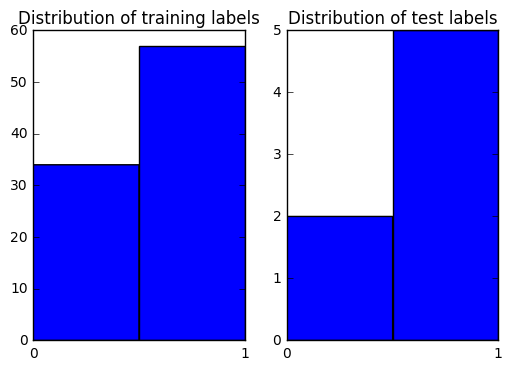

In [164]:
fig,ax = plt.subplots(1, 2)
ax[0].hist(y_train, bins=2);
#ax[0].tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
ax[0].set_xticks([0,1])
ax[0].set_title('Distribution of training labels')
ax[1].hist(y_test, bins=2);
#ax[1].tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
ax[1].set_xticks([0,1])
ax[1].set_title('Distribution of test labels');

In [118]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5),scoring='roc_auc'):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_ROC():
    pass

## Random forest

In [157]:
rf = RandomForestClassifier()
param_grid = {
    'n_estimators': [5, 10, 20, 30, 40, 50],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth': [None, 5, 10, 20]
}
CV_rf = GridSearchCV(rf, param_grid, scoring='accuracy', cv=5, verbose=1)
CV_rf.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed:   48.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'n_estimators': [5, 10, 20, 30, 40, 50], 'max_depth': [None, 5, 10, 20], 'max_features': ['auto', 'sqrt', 'log2', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [158]:
print('Best score obtained: ', CV_rf.best_score_,'\nwith parameters: ', CV_rf.best_params_)

Best score obtained:  0.725274725275 
with parameters:  {'criterion': 'gini', 'n_estimators': 30, 'max_depth': 5, 'max_features': 'auto'}


In [159]:
best_rf = CV_rf.best_estimator_
importances = best_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
cols = train_seasons.drop(['Opponent 0', 'Winner', 'Year', 'Opponent 1'], axis=1).columns
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, cols[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature GF even/GP (0.083761)
2. feature PP% (0.061788)
3. feature GF (0.054894)
4. feature GF even (0.045705)
5. feature PPT (0.043764)
6. feature GA (0.038965)
7. feature GA even (0.037339)
8. feature PK time/GP (0.036825)
9. feature GF/GP (0.034789)
10. feature GA even/GP (0.034430)
11. feature PP OP (0.033015)
12. feature PK% (0.031364)
13. feature 2'  (0.031064)
14. feature PK GA/GP (0.031061)
15. feature PP OP/GP (0.030544)
16. feature PK SI/GP (0.030165)
17. feature PK GA (0.029729)
18. feature PKT (0.028580)
19. feature PPG/GP (0.028054)
20. feature PK SI (0.026871)
21. feature 5' (0.024655)
22. feature PP GA (0.022763)
23. feature MP (0.022069)
24. feature PIM Total (0.021804)
25. feature PP time/GP (0.017862)
26. feature PP GA/GP (0.017663)
27. feature SHG (0.016009)
28. feature SOWGF (0.015655)
29. feature GA/GP (0.015443)
30. feature 10' (0.012971)
31. feature PK GF/GP (0.012729)
32. feature SOWGA (0.008955)
33. feature PPG (0.008052)
34. feature GM (0.0

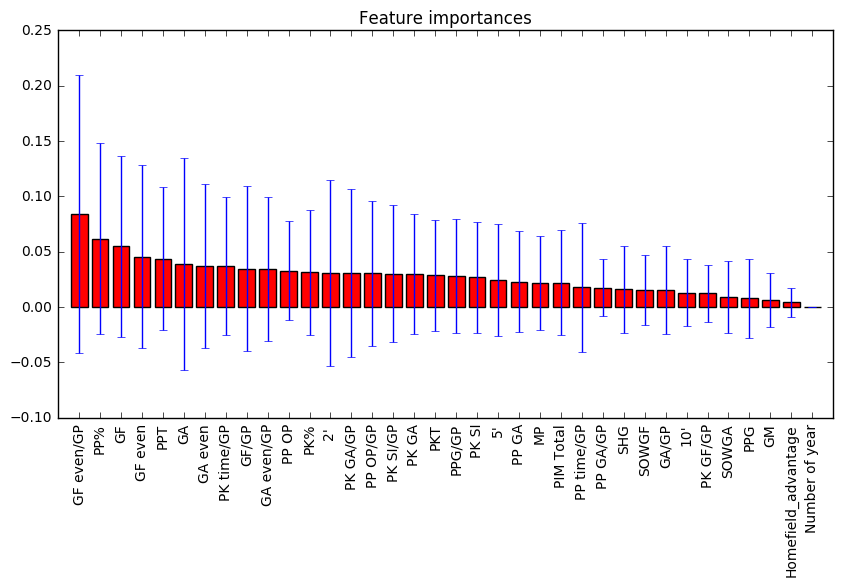

In [160]:
# Plot the feature importances of the forest
plt.figure(figsize=(10,5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices],  align='center')
plt.xticks(range(X_train.shape[1]), cols[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [86]:
restricted_feature_set = cols[indices[0:15]]
restricted_data = train_seasons[restricted_feature_set]
X_train_restricted = restricted_data.as_matrix()
X_train_restricted_norm = MinMaxScaler().fit_transform(X_train_restricted)

## MLP Classifier 

In [ ]:
param_grid = {
    'solver':['lbfgs'],
    'hidden_layer_sizes':[(10,),(30,), (50,), (80,), (100,),(10,10), (50,50)],
    'activation': ['logistic', 'tanh', 'relu'],
    'early_stopping': [True, False],
    'alpha': np.logspace(-2, 1, num=15),
    'max_iter': [1000, 2000]
}
clfncv = MLPClassifier()
cv_mlp = GridSearchCV(clfncv, param_grid, scoring='roc_auc', cv=5, verbose=1)
cv_mlp.fit(X_train_norm,y_train)

Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


In [125]:
print('Best score obtained: ', cv_mlp.best_score_,'\nwith parameters: ', cv_mlp.best_params_)

Best score obtained:  0.690868655154 
with parameters:  {'max_iter': 1000, 'early_stopping': True, 'hidden_layer_sizes': (80,), 'solver': 'lbfgs', 'alpha': 1.0, 'activation': 'logistic'}


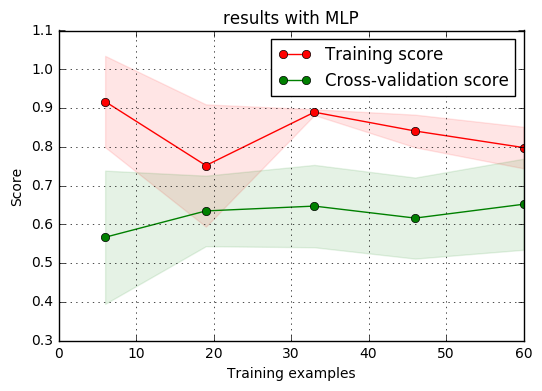

In [127]:
best_nn = cv_mlp.best_estimator_
plot_learning_curve(best_nn, 'results with MLP', X_train_norm, y_train, scoring='roc_auc');

## SVM

In [128]:
svm_model = svm.SVC()
param_grid = {
    'C': np.logspace(-2, 2, 5),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [3, 4, 5],
    'gamma': np.logspace(-3, 2, 6)
}
cv_svm = GridSearchCV(svm_model, param_grid, scoring='roc_auc', n_jobs=1, cv=5, verbose=1)
cv_svm.fit(X_train_norm, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    8.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02]), 'degree': [3, 4, 5], 'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [129]:
print('Best score obtained: ', cv_svm.best_score_,'\nwith parameters: ', cv_svm.best_params_)

Best score obtained:  0.743149707435 
with parameters:  {'kernel': 'sigmoid', 'gamma': 0.10000000000000001, 'degree': 3, 'C': 1.0}


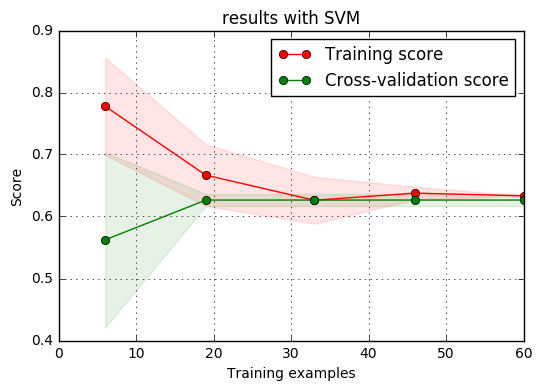

In [130]:
best_svm = cv_svm.best_estimator_
plot_learning_curve(best_svm, 'results with SVM', X_train_norm, y_train, scoring='accuracy');

Confusion matrix, without normalization
[[1 1]
 [2 3]]


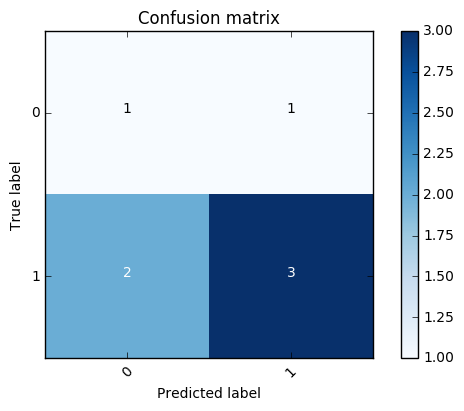

In [165]:
y_preds = best_rf.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test, y_preds), classes=[0,1])